## Caricamento file
in questa fase, bisogna importare manualmente i seguenti file:
- 2021-2022 Football Player Stats.csv;
- 2022-2023 Football Player Stats.csv;
- 2021-2022 Football Team Stats.csv;
- 2022-2023 Football Team Stats.csv;
- trend_att.pl;
- trend_mf.pl;
- trend_df.pl.

In [1]:
# Caricamento file

from google.colab import files
uploaded = files.upload()

Saving 2021-2022 Football Player Stats.csv to 2021-2022 Football Player Stats.csv
Saving 2021-2022 Football Team Stats.csv to 2021-2022 Football Team Stats.csv
Saving 2022-2023 Football Player Stats.csv to 2022-2023 Football Player Stats.csv
Saving 2022-2023 Football Team Stats.csv to 2022-2023 Football Team Stats.csv
Saving trend_att.pl to trend_att.pl
Saving trend_df.pl to trend_df.pl
Saving trend_mf.pl to trend_mf.pl


## Inizializzazione
creazione e manipolazione del file players.csv, input della base di conoscenza.

In [1]:
# definizione di funzioni di supporto
import csv
import chardet
import pandas as pd

### Gestione charset
conversione charset (Windows-1252 --> utf-8) se necessario

In [2]:
# per individuare l'encoding del file
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read())
    return result['encoding']

In [3]:
# conversione charset dei file
original_encoding = "Windows-1252"
files = ["2021-2022 Football Player Stats.csv", "2022-2023 Football Player Stats.csv",
         "2021-2022 Football Team Stats.csv", "2022-2023 Football Team Stats.csv"]
new_encoding = "utf-8"

for f in files:
  if (detect_encoding(f) == original_encoding):
    df = pd.read_csv(f, encoding = original_encoding)
    df.to_csv(f, index=False, encoding=new_encoding)

### Creazione file players.csv

In [4]:
# riduzione della tabella date le colonne da mantenere
def select_columns(file_input, columns_to_select, file_output):
    with open(file_input, mode='r') as file_csv_input:
        reader = csv.reader(file_csv_input, delimiter=';')

        headers = next(reader)  # Legge le intestazioni delle colonne
        headers = [header.strip() for header in headers]  # Rimuove spazi bianchi

        indices_selected_columns = [headers.index(column) for column in columns_to_select]

        selected_data = []

        for row in reader:
            selected_row = [row[index] for index in indices_selected_columns]
            selected_data.append(selected_row)

    with open(file_output, mode='w', newline='') as file_csv_output:
        writer = csv.writer(file_csv_output)
        writer.writerow(columns_to_select)
        writer.writerows(selected_data)


# permette estendere i file (giocatore + team) di una stagione
def estendi_dati(file_player, file_team, file_output, colonna_corrispondenza_player, colonna_corrispondenza_team):
    team_info = {}
    with open(file_team, mode='r') as file_csv_team:
        team_reader = csv.DictReader(file_csv_team)
        for row in team_reader:
            team_info[row[colonna_corrispondenza_team]] = row

    extended_data = []
    with open(file_player, mode='r') as file_csv_player:
        player_reader = csv.DictReader(file_csv_player)
        for row in player_reader:
            team_name = row[colonna_corrispondenza_player]
            if team_name in team_info:
                team_data = team_info[team_name]
                row.update(team_data)
            extended_data.append(row)

    with open(file_output, mode='w', newline='') as file_csv_output:
        fieldnames = extended_data[0].keys()
        writer = csv.DictWriter(file_csv_output, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(extended_data)


def rinomina_colonne(file_input, carattere_da_aggiungere):
    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.reader(file_csv_input)
        dati = list(lettore)  # Legge tutti i dati

    intestazioni = dati[0]  # Prima riga è l'intestazione delle colonne

    nuove_intestazioni = [colonna + carattere_da_aggiungere for colonna in intestazioni]
    dati_modificati = [nuove_intestazioni] + dati[1:]  # Aggiungi nuove intestazioni al resto dei dati

    with open(file_input, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)


# join tra i due file
def estendi_dati_player(file_player1, file_player2, file_output):
    player1_data = {}  # Dizionario per archiviare i dati dal file player1.csv

    # Leggi i dati dal file player1.csv e crea un dizionario con i nomi dei giocatori come chiavi
    with open(file_player1, mode='r') as file_csv_player1:
        player1_reader = csv.DictReader(file_csv_player1)
        for row in player1_reader:
            player1_data[row["Player"]] = row

    extended_data = []

    # Leggi i dati dal file player2.csv e estendi con i dati da player1_data quando esistono corrispondenze
    with open(file_player2, mode='r') as file_csv_player2:
        player2_reader = csv.DictReader(file_csv_player2)
        for row in player2_reader:
            player2_name = row["Player2"]
            if player2_name in player1_data:
                player1_row = player1_data[player2_name]
                row.update(player1_row)
                extended_data.append(row)

    # Scrivi i dati estesi nel file di output
    with open(file_output, mode='w', newline='') as file_csv_output:
        fieldnames = extended_data[0].keys()
        writer = csv.DictWriter(file_csv_output, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(extended_data)


def rimuovi_colonna(file_input, colonna_da_rimuovere, file_output):
    dati_modificati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.reader(file_csv_input)
        intestazioni = next(lettore)  # Legge le intestazioni delle colonne
        indice_colonna_rimuovere = intestazioni.index(colonna_da_rimuovere)

        nuove_intestazioni = [colonna for colonna in intestazioni if colonna != colonna_da_rimuovere]
        dati_modificati.append(nuove_intestazioni)

        for riga in lettore:
            nuova_riga = [valore for indice, valore in enumerate(riga) if indice != indice_colonna_rimuovere]
            dati_modificati.append(nuova_riga)

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)


def modifica_colonna_player(file_input, file_output):
    dati_modificati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.DictReader(file_csv_input)
        intestazioni = lettore.fieldnames  # Legge le intestazioni delle colonne
        dati_modificati.append(intestazioni)

        for riga in lettore:
            # Modifica il valore della colonna "Player"
            riga["Player"] = riga["Player"].replace("'", "")  # Sostituisci ' con uno spazio
            riga["Player"] = riga["Player"].replace(" ", "_")
            dati_modificati.append([riga[colonna] for colonna in intestazioni])

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)

def rimuovi_righe_condizione(file_input, file_output):
    dati_modificati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.DictReader(file_csv_input)
        intestazioni = lettore.fieldnames  # Legge le intestazioni delle colonne
        dati_modificati.append(intestazioni)

        for riga in lettore:
            ruolo = riga.get("Pos")
            if ruolo in ["DF", "MF", "FW"]:
                dati_modificati.append([riga[colonna] for colonna in intestazioni])

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)


def rimuovi_pochi_min(file_input, file_output):
    dati_modificati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.DictReader(file_csv_input)
        intestazioni = lettore.fieldnames  # Legge le intestazioni delle colonne
        dati_modificati.append(intestazioni)

        for riga in lettore:
            if float(riga.get("90s", 0)) >= 2 and float(riga.get("90s2", 0)) >= 2:
                dati_modificati.append([riga[colonna] for colonna in intestazioni])

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)

def rimuovi_no_gol(file_input, file_output):
    dati_modificati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.DictReader(file_csv_input)
        intestazioni = lettore.fieldnames  # Legge le intestazioni delle colonne
        dati_modificati.append(intestazioni)

        for riga in lettore:
            if riga.get("GF2"):  # Verifica che il valore della colonna "GF2" sia presente
                dati_modificati.append([riga[colonna] for colonna in intestazioni])

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)

In [5]:
# Riduzione delle feature per ognuno dei dataset di partenza

player_col = ["Player", "Squad", "Age", "Pos", "90s", "Goals", "PasTotCmp%", "Assists", "GCA", "SCA", "TklWon", "Int", "Err", "CrdY", "CrdR", "Fls", "AerWon%"]
team_col = ["Squad", "GF", "GA", "Pts/G"]

select_columns("2021-2022 Football Player Stats.csv", player_col, "player2122.csv")
select_columns("2022-2023 Football Player Stats.csv", player_col, "player2223.csv")
select_columns("2021-2022 Football Team Stats.csv", team_col, "team2122.csv")
select_columns("2022-2023 Football Team Stats.csv", team_col, "team2223.csv")

In [6]:
file_player = "player2122.csv"
file_team = "team2122.csv"
file_output = "player_extended2122.csv"

estendi_dati(file_player, file_team, file_output, 'Squad', 'Squad')
print(f"Dati estesi scritti nel file {file_output}.")

Dati estesi scritti nel file player_extended2122.csv.


In [7]:
file_player = "player2223.csv"
file_team = "team2223.csv"
file_output = "player_extended2223.csv"

estendi_dati(file_player, file_team, file_output, 'Squad', 'Squad')
print(f"Dati estesi scritti nel file {file_output}.")

Dati estesi scritti nel file player_extended2223.csv.


In [8]:
file_input = "player_extended2223.csv"
carattere_da_aggiungere = "2"
rinomina_colonne(file_input, carattere_da_aggiungere)
print("Colonne rinominate con successo.")

Colonne rinominate con successo.


In [9]:
file_player1 = "player_extended2122.csv"
file_player2 = "player_extended2223.csv"
file_output = "players.csv"

estendi_dati_player(file_player1, file_player2, file_output)
print(f"Dati estesi scritti nel file {file_output}.")

Dati estesi scritti nel file players.csv.


In [10]:
file_input = "players.csv"
colonna_da_rimuovere = "Player2"
file_output = "players.csv"

rimuovi_colonna(file_input, colonna_da_rimuovere, file_output)
print(f"Colonna rimossa. Dati scritti nel file {file_output}.")

Colonna rimossa. Dati scritti nel file players.csv.


In [11]:
file_input = "players.csv"

modifica_colonna_player(file_input, file_input)
print(f"Colonna 'Player' modificata. Dati scritti nel file {file_output}.")

Colonna 'Player' modificata. Dati scritti nel file players.csv.


In [12]:
rimuovi_righe_condizione("players.csv", "players.csv")
rimuovi_pochi_min("players.csv", "players.csv")
rimuovi_no_gol("players.csv", "players.csv")

## Applicazione base di conoscenza

In [13]:
!apt-get install -y swi-prolog
!pip install pyswip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swi-prolog is already the newest version (8.4.2+dfsg-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [14]:
import pyswip
from pyswip import Prolog

In [15]:
# creazione di un nuovo file csv possedente le colonne selezionate
def seleziona_colonne(file_input, colonne_da_selezionare, file_output):
    dati_selezionati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.DictReader(file_csv_input)
        intestazioni = lettore.fieldnames
        indici_colonne_selezionate = [intestazioni.index(colonna) for colonna in colonne_da_selezionare]
        dati_selezionati.append(colonne_da_selezionare)

        for riga in lettore:
            riga_selezionata = [riga[colonna] for colonna in colonne_da_selezionare]
            dati_selezionati.append(riga_selezionata)

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_selezionati)


def sostituisci_nome_colonna(file_csv, nome_colonna_da_sostituire, nuovo_nome):
    # Leggi il file CSV utilizzando pandas
    dataframe = pd.read_csv(file_csv)

    # Verifica se la colonna da sostituire esiste nel dataframe
    if nome_colonna_da_sostituire in dataframe.columns:
        # Rinomina la colonna con il nuovo nome
        dataframe.rename(columns={nome_colonna_da_sostituire: nuovo_nome}, inplace=True)

        # Salva le modifiche nel file CSV
        dataframe.to_csv(file_csv, index=False)
        print(f"Colonna '{nome_colonna_da_sostituire}' sostituita con '{nuovo_nome}' nel file '{file_csv}'.")
    else:
        print(f"La colonna '{nome_colonna_da_sostituire}' non è presente nel file '{file_csv}'.")


def esegui_query_prolog(file_prolog, file_csv):
    prolog = Prolog()
    prolog.consult(file_prolog)  # Carica le clausole dal file Prolog

    results = []

    with open(file_csv, newline="") as csvfile:
        csvreader = csv.reader(csvfile)
        intestazioni = next(csvreader)
        intestazioni.append("Trend")  # Aggiungi la colonna "Trend" all'intestazione
        results.append(intestazioni)

        for row in csvreader:
            player = row[0]  # Nome del giocatore dalla colonna 0
            player_formatted = f"'{player}'"

            query = f"trend({player_formatted}, Trend)"
            result = list(prolog.query(query))

            if result:
                trend_value = result[0]["Trend"]
                row.append(trend_value)  # Aggiungi il valore di "Trend" alla riga
                results.append(row)
            else:
                row.append("")  # Aggiungi cella vuota se non c'è risultato
                results.append(row)

    return results


def solo_attaccanti(file_input, file_output):
    dati_modificati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.DictReader(file_csv_input)
        intestazioni = lettore.fieldnames
        dati_modificati.append(intestazioni)

        for riga in lettore:
            ruolo = riga.get("Pos")
            if ruolo in ["FW"]:
                dati_modificati.append([riga[colonna] for colonna in intestazioni])

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)


def solo_centrocampisti(file_input, file_output):
    dati_modificati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.DictReader(file_csv_input)
        intestazioni = lettore.fieldnames  #
        dati_modificati.append(intestazioni)

        for riga in lettore:
            ruolo = riga.get("Pos")
            if ruolo in ["MF"]:
                dati_modificati.append([riga[colonna] for colonna in intestazioni])

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)


def solo_difensori(file_input, file_output):
    dati_modificati = []

    with open(file_input, mode='r') as file_csv_input:
        lettore = csv.DictReader(file_csv_input)
        intestazioni = lettore.fieldnames
        dati_modificati.append(intestazioni)

        for riga in lettore:
            ruolo = riga.get("Pos")
            if ruolo in ["DF"]:
                dati_modificati.append([riga[colonna] for colonna in intestazioni])

    with open(file_output, mode='w', newline='') as file_csv_output:
        scrittore = csv.writer(file_csv_output)
        scrittore.writerows(dati_modificati)

### Applicazione base di conoscenza agli attaccanti

In [16]:
# Opportune modifiche al file per compatibilità con Prolog
file_input = "players.csv"
colonne_da_selezionare = ["Player", "Age", "Pos", "90s", "90s2", "Goals", "Goals2", "GCA", "GCA2", "GF", "GF2"]
file_output = "players_fw.csv"

seleziona_colonne("players.csv", colonne_da_selezionare, "players_fw.csv")
solo_attaccanti("players_fw.csv", "players_fw.csv")
rimuovi_colonna("players_fw.csv", "Pos", "players_fw.csv")
sostituisci_nome_colonna(file_output, "90s", "Games")
sostituisci_nome_colonna(file_output, "90s2", "Games2")

# Interrogazione al file Prolog
prolog = Prolog()
prolog.consult("trend_att.pl")

file_prolog = "trend_att.pl"
file_csv = "players_fw.csv"

risultati_query = esegui_query_prolog(file_prolog, file_csv)

# Sovrascrivi il file CSV con i risultati di "Trend" aggiunti
with open("players_fw_trend.csv", "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(risultati_query)

print("Risultati di Trend aggiunti al file CSV.")

Colonna '90s' sostituita con 'Games' nel file 'players_fw.csv'.
Colonna '90s2' sostituita con 'Games2' nel file 'players_fw.csv'.
Risultati di Trend aggiunti al file CSV.


### Applicazione base di conoscenza ai centrocampisti

In [17]:
file_input = "players.csv"
colonne_da_selezionare = ["Player", "Age", "Pos", "90s", "90s2", "PasTotCmp%", "PasTotCmp%2", "GCA", "GCA2", "GF", "GF2"]
file_output = "players_mf.csv"

seleziona_colonne(file_input, colonne_da_selezionare, file_output)
solo_centrocampisti(file_output, file_output)
rimuovi_colonna(file_output, "Pos", file_output)
sostituisci_nome_colonna(file_output, "90s", "Games")
sostituisci_nome_colonna(file_output, "90s2", "Games2")
sostituisci_nome_colonna(file_output, "PasTotCmp%", "PTC")
sostituisci_nome_colonna(file_output, "PasTotCmp%2", "PTC2")

prolog = Prolog()
prolog.consult("trend_mf.pl")

file_prolog = "trend_mf.pl"
file_csv = "players_mf.csv"

risultati_query = esegui_query_prolog(file_prolog, file_csv)

# Sovrascrivi il file CSV con i risultati di "Trend" aggiunti
with open("players_mf_trend.csv", "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(risultati_query)

print("Risultati di Trend aggiunti al file CSV.")

Colonna '90s' sostituita con 'Games' nel file 'players_mf.csv'.
Colonna '90s2' sostituita con 'Games2' nel file 'players_mf.csv'.
Colonna 'PasTotCmp%' sostituita con 'PTC' nel file 'players_mf.csv'.
Colonna 'PasTotCmp%2' sostituita con 'PTC2' nel file 'players_mf.csv'.
Risultati di Trend aggiunti al file CSV.


### Applicazione base di conoscenza ai difensori

In [18]:
file_input = "players.csv"
colonne_da_selezionare = ["Player", "Age", "Pos", "90s", "90s2", "TklWon", "TklWon2", "Err", "Err2", "GA", "GA2"]
file_output = "players_df.csv"

seleziona_colonne(file_input, colonne_da_selezionare, file_output)
solo_difensori(file_output, file_output)
rimuovi_colonna(file_output, "Pos", file_output)
sostituisci_nome_colonna(file_output, "90s", "Games")
sostituisci_nome_colonna(file_output, "90s2", "Games2")

prolog = Prolog()
prolog.consult("trend_df.pl")

file_prolog = "trend_df.pl"
file_csv = "players_df.csv"

risultati_query = esegui_query_prolog(file_prolog, file_csv)

# Sovrascrivi il file CSV con i risultati di "Trend" aggiunti
with open("players_df_trend.csv", "w", newline="") as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(risultati_query)

print("Risultati di Trend aggiunti al file CSV.")

Colonna '90s' sostituita con 'Games' nel file 'players_df.csv'.
Colonna '90s2' sostituita con 'Games2' nel file 'players_df.csv'.
Risultati di Trend aggiunti al file CSV.


## Creazione dataset
Creazione dei dataset:
- players_data.csv;
- players_data2.csv (selezione di feature).

In [19]:
# funzione che permette di unificare le tabelle
def merge_csv_tables(file1, file2, file3, output_file):
    # Carica i file CSV in tre DataFrame separati
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    df3 = pd.read_csv(file3)

    combined_df = pd.concat([df1, df2, df3], ignore_index=True)

    combined_df.to_csv(output_file, index=False)


# funzione che consente di effettuare l'operazione di join tra le tabelle
def merge_and_add_column(file1, file2, same_cols, col, output_file):
    # Carica i file CSV in due DataFrame separati
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    merged_df = pd.merge(df1, df2, on=same_cols)

    merged_df.to_csv(output_file, index=False)


def convert_trend_values(input_file, output_file, column_name):

    data = pd.read_csv(input_file)

    value_mapping = {
        'very_bad': 0,
        'bad': 1,
        'static': 2,
        'good': 3,
        'very_good': 4
    }

    # Applica la trasformazione alla colonna desiderata
    data[column_name] = data[column_name].map(value_mapping)

    data.to_csv(output_file, index=False)


def convert_pos_values(input_file, output_file, column_name):

    data = pd.read_csv(input_file)

    value_mapping = {
        'DF': 0,
        'MF': 1,
        'FW': 2,
    }

    # Applica la trasformazione alla colonna desiderata
    data[column_name] = data[column_name].map(value_mapping)

    data.to_csv(output_file, index=False)

In [20]:
# riduzione delle tre tabelle appena ottenute allo scopo di poterle unificare in una sola tabella
colonne_comuni = ['Player', 'Age', 'Trend']
file_list = ["players_fw_trend.csv", "players_mf_trend.csv", "players_df_trend.csv"]

for f in file_list:
  seleziona_colonne(f, colonne_comuni, f)

merge_csv_tables(file_list[0], file_list[1], file_list[2], "players_trend.csv")

colonne_uguali = ["Player", "Age"]
nuova_colonna = "Trend"

merge_and_add_column("players.csv", "players_trend.csv", colonne_uguali, nuova_colonna, "players_trend2.csv")

parameters = ["Age", "Pos", "90s", "Goals", "Assists", "GCA", "SCA", "PasTotCmp%", "TklWon", "Int", "Err", "GF", "GA", "Pts/G", "Trend"]

seleziona_colonne("players_trend2.csv", parameters, "players_data.csv")

In [21]:
# preparazione di un file csv con un numero di feature ridotto
feature_names = ["Age", "Pos", "90s", "GCA", "PasTotCmp%", "TklWon", "GF", "GA", "Trend"]

# Carica il file CSV esistente
file_input = 'players_data.csv'
df = pd.read_csv(file_input)

# Crea un nuovo DataFrame contenente solo le colonne desiderate
df_nuovo = df[feature_names]

# Salva il nuovo DataFrame in un nuovo file CSV
file_output = 'players_data2.csv'
df_nuovo.to_csv(file_output, index=False)

In [22]:
column = 'Trend'
file_players = "players_data.csv"
file_players2 = "players_data2.csv"
convert_trend_values(file_players, file_players, column)
convert_trend_values(file_players2, file_players2, column)

In [23]:
column = 'Pos'
file_players = "players_data.csv"
file_players2 = "players_data2.csv"
convert_pos_values(file_players, file_players, column)
convert_pos_values(file_players2, file_players2, column)

### Matrice di correlazione
Blocco utile alla visualizzazione grafica delle correlazioni delle feature.

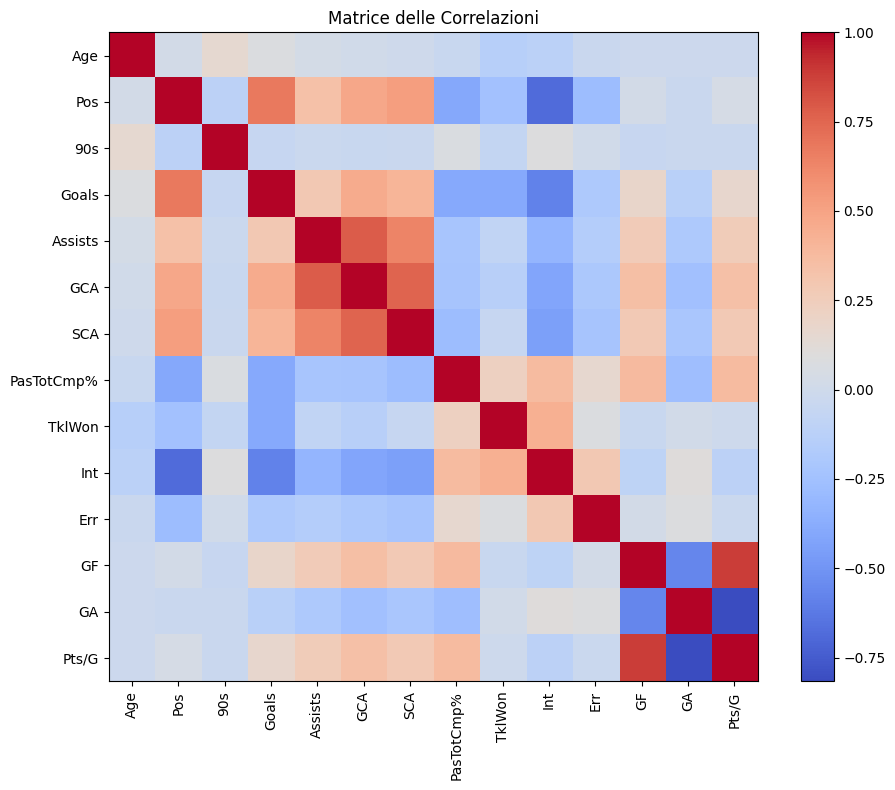

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i dati dal file CSV
df = pd.read_csv('players_data.csv')

# Escludi la colonna 'Trend' dal calcolo delle correlazioni
features_to_include = df.columns.drop(['Trend'])
correlation_matrix = df[features_to_include].corr()

# Crea un grafico della matrice delle correlazioni come immagine
plt.figure(figsize=(10, 8))  # Imposta le dimensioni della figura
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()  # Aggiungi una barra dei colori
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Matrice delle Correlazioni')  # Aggiungi un titolo

# Mostra l'immagine
plt.tight_layout()
plt.show()

## Random undersampling

In [25]:
pip install -U imbalanced-learn

In [26]:
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

dataset = pd.read_csv("players_data.csv")

# Estrai le caratteristiche (features) e la variabile target
X = dataset.iloc[:, :-1]
y = dataset["Trend"]

sampling_strategy = {
    0 : 48,
    1 : 150,
    2 : 250,
    3 : 150,
    4 : 48
}

# Creazione dei due insiemi sottocampionati
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [27]:
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

dataset = pd.read_csv("players_data2.csv")

# Estrai le caratteristiche (features) e la variabile target
X2 = dataset.iloc[:, :-1]
y2 = dataset["Trend"]

sampling_strategy = {
    0 : 48,
    1 : 150,
    2 : 200,
    3 : 192,
    4 : 48
}

# Creazione dei due insiemi sottocampionati
rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled2, y_resampled2 = rus.fit_resample(X2, y2)

## Stampa matrice di confusione
una volta ottenuta la matrice di confusione di un modello, eseguo per stampare la matrice di confusione conf_matrix

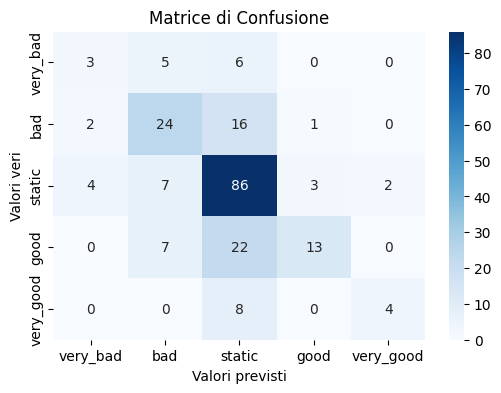

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Etichette delle classi, in ordine di visualizzazione
class_labels = ["very_bad", "bad", "static", "good", "very_good"]

# Creazione della heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Valori previsti")
plt.ylabel("Valori veri")
plt.title("Matrice di Confusione")
plt.show()

## K-Nearest Neighbor

In [ ]:
# KNN - primo caso
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, log_loss, confusion_matrix, f1_score
from sklearn.preprocessing import LabelBinarizer

# Carica i dati
data = pd.read_csv("players_data.csv")

# weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
weights = [1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
# weights = [1.0, 1.0, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33]

# Preparazione dei dati
X = data.iloc[:, :-1]
y = data["Trend"]

# Normalizzazione delle feature
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled * weights

# Split dei dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Creazione del modello KNN
knn = KNeighborsClassifier()

# Definizione dei parametri per la grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 10],
    'weights': ['uniform', 'distance'],
    'metric' : ['cosine', 'l1', 'l2']
}

# Grid search per la ricerca degli iperparametri ottimali
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall_weighted')
grid_search.fit(X_train, y_train)

# Miglior modello trovato dalla grid search
best_knn = grid_search.best_estimator_

# Valutazione del modello migliore
y_pred = best_knn.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_test)
y_true_binarized = lb.transform(y_test)

# Calcolo delle probabilità previste dal modello migliore
y_prob = best_knn.predict_proba(X_test)

# ROC-AUC
roc_auc = roc_auc_score(y_true_binarized, y_prob, average="weighted")

# Log Loss
logloss = log_loss(y_test, y_prob)

print("Parametri Ottimali:")
print(grid_search.best_params_)

print("Media delle prestazioni:", grid_search.best_score_)
print("Deviazione standard delle prestazioni:", grid_search.cv_results_['std_test_score'][grid_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

In [ ]:
# KNN - feature ridotte
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, log_loss, confusion_matrix, f1_score
from sklearn.preprocessing import LabelBinarizer

# Carica i dati
data = pd.read_csv("players_data2.csv")

# weights = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# weights = [1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
weights = [1.0, 1.0, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33]

# Preparazione dei dati
X = data.iloc[:, :-1]
y = data["Trend"]

# Normalizzazione delle feature
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled * weights

# Split dei dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Creazione del modello KNN
knn = KNeighborsClassifier()

# Definizione dei parametri per la grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 10],
    'weights': ['uniform', 'distance'],
    'metric' : ['cosine', 'l1', 'l2']
}

# Grid search per la ricerca degli iperparametri ottimali
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall_weighted')
grid_search.fit(X_train, y_train)

# Miglior modello trovato dalla grid search
best_knn = grid_search.best_estimator_

# Valutazione del modello migliore
y_pred = best_knn.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_test)
y_true_binarized = lb.transform(y_test)

# Calcolo delle probabilità previste dal modello migliore
y_prob = best_knn.predict_proba(X_test)

# ROC-AUC
roc_auc = roc_auc_score(y_true_binarized, y_prob, average="weighted")

# Log Loss
logloss = log_loss(y_test, y_prob)

print("Parametri Ottimali:")
print(grid_search.best_params_)

print("Media delle prestazioni:", grid_search.best_score_)
print("Deviazione standard delle prestazioni:", grid_search.cv_results_['std_test_score'][grid_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

## SVM

In [ ]:
# SVM per la classificazione multi-classe con grid search
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler

data = pd.read_csv("players_data.csv")

X = data.iloc[:, :-1]
y = data["Trend"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

n_splits = 5

# Crea un oggetto KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Definisci una griglia dei parametri da cercare
param_grid = {
    'C': [0.1, 1, 5, 6, 7, 8, 9, 10],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC(decision_function_shape='ovr', probability=True)

# Crea un oggetto GridSearchCV con K-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='recall_weighted', cv=kf)

# Esegui la ricerca dei parametri ottimali
grid_search.fit(X_train, y_train)

# Stampare i parametri selezionati a seguito della grid search
print("Parametri Ottimali:")
print(grid_search.best_params_)

# Il miglior modello è già addestrato su tutto il set di addestramento
best_svm = grid_search.best_estimator_

# Calcola le prestazioni del miglior modello durante la cross-validation
cv_results = cross_val_score(best_svm, X_train, y_train, cv=5, scoring='recall_weighted')

print("Risultati della K-fold Cross-Validation per il Miglior Modello:")
print(f'Media: {cv_results.mean()}')
print(f'Deviazione Standard: {cv_results.std()}')
print(f'Resultati per ogni fold: {cv_results}')
print('\n\n')


# Fai previsioni con il miglior modello
y_pred = best_svm.predict(X_test)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = best_svm.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

In [32]:
# SVM con feature selection
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler

data = pd.read_csv("players_data2.csv")

X = data.iloc[:, :-1]
y = data["Trend"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

n_splits = 5

# Crea un oggetto KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Definisci una griglia dei parametri da cercare
param_grid = {
    'C': [0.1, 1, 5, 6, 7, 8, 9, 10],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm = SVC(decision_function_shape='ovr', probability=True)

# Crea un oggetto GridSearchCV con K-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='recall_weighted', cv=kf)

# Esegui la ricerca dei parametri ottimali
grid_search.fit(X_train, y_train)

# Stampare i parametri selezionati a seguito della grid search
print("Parametri Ottimali:")
print(grid_search.best_params_)

# Il miglior modello è già addestrato su tutto il set di addestramento
best_svm = grid_search.best_estimator_

# Calcola le prestazioni del miglior modello durante la cross-validation
cv_results = cross_val_score(best_svm, X_train, y_train, cv=5, scoring='recall_weighted')

print("Risultati della K-fold Cross-Validation per il Miglior Modello:")
print(f'Media: {cv_results.mean()}')
print(f'Deviazione Standard: {cv_results.std()}')
print(f'Resultati per ogni fold: {cv_results}')
print('\n\n')


# Fai previsioni con il miglior modello
y_pred = best_svm.predict(X_test)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = best_svm.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)


Parametri Ottimali:
{'C': 8, 'gamma': 'auto', 'kernel': 'rbf'}
Risultati della K-fold Cross-Validation per il Miglior Modello:
Media: 0.5740075679394565
Deviazione Standard: 0.028099076564225514
Resultati per ogni fold: [0.52046784 0.57309942 0.6        0.58823529 0.58823529]



Precision: 0.6213593010178148
Recall: 0.6103286384976526
F1-score: 0.5849482714678309
ROC-AUC: 0.7864331183964166
Log Loss: 0.9779012325044083
Matrice di Confusione:
[[ 3  5  6  0  0]
 [ 2 24 16  1  0]
 [ 4  7 86  3  2]
 [ 0  7 22 13  0]
 [ 0  0  8  0  4]]


In [30]:
# SVM (Grid Search + Undersampling)
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import RandomUnderSampler

# Dividi il set di dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Definisci una griglia dei parametri da cercare
param_grid = {
    'C': [0.1, 1, 5, 6, 7, 8, 9, 10],
    'kernel': ['poly'],
}

svm = SVC(decision_function_shape='ovr', probability=True)

# Crea un oggetto GridSearchCV con K-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='recall_weighted', cv=5)

# Esegui la ricerca dei parametri ottimali
grid_search.fit(X_train, y_train)

# Stampare i parametri selezionati a seguito della grid search
print("Parametri Ottimali:")
print(grid_search.best_params_)

# Il miglior modello è già addestrato su tutto il set di addestramento
best_svm = grid_search.best_estimator_

# Calcola le prestazioni del miglior modello durante la cross-validation
cv_results = cross_val_score(best_svm, X_train, y_train, cv=5, scoring='recall_weighted')

print("Risultati della K-fold Cross-Validation per il Miglior Modello:")
print(f'Media: {cv_results.mean()}')
print(f'Deviazione Standard: {cv_results.std()}')
print(f'Resultati per ogni fold: {cv_results}')
print('\n\n')


# Fai previsioni con il miglior modello
y_pred = best_svm.predict(X_test)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = best_svm.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

Parametri Ottimali:
{'C': 9, 'kernel': 'poly'}
Risultati della K-fold Cross-Validation per il Miglior Modello:
Media: 0.4224421209858103
Deviazione Standard: 0.023475652650573907
Resultati per ogni fold: [0.44230769 0.45631068 0.41747573 0.39805825 0.39805825]



Precision: 0.27833695430782807
Recall: 0.4076923076923077
F1-score: 0.3079920931583336
ROC-AUC: 0.7126987179487179
Log Loss: 1.1613211027821277
Matrice di Confusione:
[[ 5  4  1  0  0]
 [ 1  6 23  0  0]
 [ 5  3 42  0  0]
 [ 0  3 27  0  0]
 [ 0  0 10  0  0]]


## Random Forest

In [29]:
pip install scikit-optimize

In [30]:
## RF - primo caso
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Carica i dati
data = pd.read_csv("players_data.csv")

# Preparazione dei dati
X = data.iloc[:, :-1]
y = data["Trend"]
c = data["Pos"]

# Dividi il set di dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definizione dei possibili valori degli iperparametri da esplorare
param_grid = {
    'n_estimators': [60, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crea un oggetto Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='recall_weighted')

# Esegui la ricerca degli iperparametri sul set di addestramento
grid_search.fit(X_train, y_train)

# Estrai il miglior modello dai risultati della ricerca
best_model = grid_search.best_estimator_

# Valutazione del modello migliore attraverso la k-fold cross-validation sul set di addestramento
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall_weighted')

# Stampa delle metriche di valutazione per ciascuna fold
for i, score in enumerate(scores, start=1):
    print(f"Fold {i}: metric = {score:.2f}")

# Stampa della media e deviazione standard delle metriche di valutazione
print(f"Mean metric: {scores.mean():.2f}")
print(f"Standard deviation metric: {scores.std():.2f}")

# Addestramento del modello sul set di addestramento completo
best_model.fit(X_train, y_train)

# Predizioni sul set di test
y_pred = best_model.predict(X_test)

# Calcolo delle metriche sul set di test
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo log loss
y_prob = best_model.predict_proba(X_test)
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(grid_search.best_params_)

print("Media delle prestazioni:", grid_search.best_score_)
print("Deviazione standard delle prestazioni:", grid_search.cv_results_['std_test_score'][grid_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)


Fold 1: metric = 0.64
Fold 2: metric = 0.64
Fold 3: metric = 0.67
Fold 4: metric = 0.67
Fold 5: metric = 0.59
Mean metric: 0.64
Standard deviation metric: 0.03
Parametri Ottimali:
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 60}
Media delle prestazioni: 0.6431991744066047
Deviazione standard delle prestazioni: 0.028080749676016398
Precision: 0.6157835045555735
Recall: 0.5915492957746479
F1-score: 0.5553960633811453
ROC-AUC: 0.8118674230229962
Log Loss: 0.9191114524127941
Matrice di Confusione:
[[ 4  4  6  0  0]
 [ 2 21 17  2  0]
 [ 4 10 89  1  0]
 [ 0  9 19 10  0]
 [ 0  0 11  2  2]]


In [38]:
## RF - random undersampling
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Dividi il set di dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Definizione dei possibili valori degli iperparametri da esplorare
param_grid = {
    'n_estimators': [60, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crea un oggetto Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='recall_weighted')

# Esegui la ricerca degli iperparametri sul set di addestramento
grid_search.fit(X_train, y_train)

# Estrai il miglior modello dai risultati della ricerca
best_model = grid_search.best_estimator_

# Valutazione del modello migliore attraverso la k-fold cross-validation sul set di addestramento
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall_weighted')

# Stampa delle metriche di valutazione per ciascuna fold
for i, score in enumerate(scores, start=1):
    print(f"Fold {i}: metric = {score:.2f}")

# Stampa della media e deviazione standard delle metriche di valutazione
print(f"Mean metric: {scores.mean():.2f}")
print(f"Standard deviation metric: {scores.std():.2f}")

# Addestramento del modello sul set di addestramento completo
best_model.fit(X_train, y_train)

# Predizioni sul set di test
y_pred = best_model.predict(X_test)

# Calcolo delle metriche sul set di test
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo log loss
y_prob = best_model.predict_proba(X_test)
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(grid_search.best_params_)

print("Media delle prestazioni:", grid_search.best_score_)
print("Deviazione standard delle prestazioni:", grid_search.cv_results_['std_test_score'][grid_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)


Fold 1: metric = 0.62
Fold 2: metric = 0.60
Fold 3: metric = 0.62
Fold 4: metric = 0.63
Fold 5: metric = 0.63
Mean metric: 0.62
Standard deviation metric: 0.01
Parametri Ottimali:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Media delle prestazioni: 0.6220873786407768
Deviazione standard delle prestazioni: 0.01073463319781362
Precision: 0.5925074925074925
Recall: 0.5692307692307692
F1-score: 0.5584845832633443
ROC-AUC: 0.8016602564102565
Log Loss: 1.0016915546376992
Matrice di Confusione:
[[ 6  1  3  0  0]
 [ 1 18 11  0  0]
 [ 4  5 36  5  0]
 [ 0 12  9  9  0]
 [ 0  0  4  1  5]]


In [34]:
## RF con scelta degli iperparametri tramite ottimizzazione bayesiana
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.preprocessing import LabelBinarizer

# Carica i dati
data = pd.read_csv("players_data.csv")

# Preparazione dei dati
X = data.iloc[:, :-1]
y = data["Trend"]

# Dividi il set di dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definizione dei possibili valori degli iperparametri e dei loro range
param_dist = {
    'n_estimators': (50, 200),  # Range per il numero di stimatori
    'max_depth': (5, 20),  # Range per la massima profondità
    'min_samples_split': (2, 10),  # Range per il numero minimo di campioni richiesti per suddividere un nodo
    'min_samples_leaf': (1, 4),  # Range per il numero minimo di campioni richiesti per una foglia
}

# Crea un oggetto Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Crea un oggetto BayesSearchCV per la ricerca degli iperparametri basata su ottimizzazione bayesiana
bayes_search = BayesSearchCV(
    random_forest,
    param_dist,
    cv=5,
    scoring='recall_weighted',
    n_iter=50,
    random_state=42
)

# Esegui la ricerca degli iperparametri sul set di addestramento
bayes_search.fit(X_train, y_train)

# Estrai il miglior modello dai risultati della ricerca
best_model = bayes_search.best_estimator_

# Valutazione del modello migliore attraverso la k-fold cross-validation sul set di addestramento
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall_weighted')

# Stampa delle metriche di valutazione per ciascuna fold
for i, score in enumerate(scores, start=1):
    print(f"Fold {i}: metric = {score:.2f}")

# Stampa della media e deviazione standard delle metriche di valutazione
print(f"Mean metric: {scores.mean():.2f}")
print(f"Standard deviation metric: {scores.std():.2f}")

# Addestramento del modello sul set di addestramento completo
best_model.fit(X_train, y_train)

# Predizioni sul set di test
y_pred = best_model.predict(X_test)

# Calcolo delle metriche sul set di test
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo log loss
y_prob = best_model.predict_proba(X_test)
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(bayes_search.best_params_)

print("Media delle prestazioni:", bayes_search.best_score_)
print("Deviazione standard delle prestazioni:", bayes_search.cv_results_['std_test_score'][bayes_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fold 1: metric = 0.64
Fold 2: metric = 0.66
Fold 3: metric = 0.67
Fold 4: metric = 0.66
Fold 5: metric = 0.61
Mean metric: 0.65
Standard deviation metric: 0.02
Parametri Ottimali:
OrderedDict([('max_depth', 13), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 50)])
Media delle prestazioni: 0.6478844169246646
Deviazione standard delle prestazioni: 0.023829620732157483
Precision: 0.6570106607301609
Recall: 0.6197183098591549
F1-score: 0.5805661780691148
ROC-AUC: 0.8133267788744681
Log Loss: 0.9423002081928715
Matrice di Confusione:
[[ 5  3  6  0  0]
 [ 1 26 15  0  0]
 [ 3 10 90  1  0]
 [ 0  9 20  9  0]
 [ 0  0 11  2  2]]


In [33]:
## Esperimento: ottimizzazione bayesiana + undersampling
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
import matplotlib.pyplot as plt


# Dividi il set di dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Definizione dei possibili valori degli iperparametri e dei loro range
param_dist = {
    'n_estimators': (50, 200),  # Range per il numero di stimatori
    'max_depth': (5, 20),  # Range per la massima profondità
    'min_samples_split': (2, 10),  # Range per il numero minimo di campioni richiesti per suddividere un nodo
    'min_samples_leaf': (1, 4),  # Range per il numero minimo di campioni richiesti per una foglia
}

# Crea un oggetto Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Crea un oggetto BayesSearchCV per la ricerca degli iperparametri basata su ottimizzazione bayesiana
bayes_search = BayesSearchCV(
    random_forest,
    param_dist,
    cv=5,
    scoring='recall_weighted',
    n_iter=50,  # Numero di iterazioni per la ricerca
    random_state=42
)

# Esegui la ricerca degli iperparametri sul set di addestramento
bayes_search.fit(X_train, y_train)

# Estrai il miglior modello dai risultati della ricerca
best_model = bayes_search.best_estimator_

# Valutazione del modello migliore attraverso la k-fold cross-validation sul set di addestramento
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall_weighted')

# Stampa delle metriche di valutazione per ciascuna fold
for i, score in enumerate(scores, start=1):
    print(f"Fold {i}: metric = {score:.2f}")

# Stampa della media e deviazione standard delle metriche di valutazione
print(f"Mean metric: {scores.mean():.2f}")
print(f"Standard deviation metric: {scores.std():.2f}")

# Addestramento del modello sul set di addestramento completo
best_model.fit(X_train, y_train)

# Predizioni sul set di test
y_pred = best_model.predict(X_test)

# Calcolo delle metriche sul set di test
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo log loss
y_prob = best_model.predict_proba(X_test)
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(bayes_search.best_params_)

print("Media delle prestazioni:", bayes_search.best_score_)
print("Deviazione standard delle prestazioni:", bayes_search.cv_results_['std_test_score'][bayes_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

Fold 1: metric = 0.59
Fold 2: metric = 0.62
Fold 3: metric = 0.62
Fold 4: metric = 0.59
Fold 5: metric = 0.65
Mean metric: 0.61
Standard deviation metric: 0.02
Parametri Ottimali:
OrderedDict([('max_depth', 18), ('min_samples_leaf', 2), ('min_samples_split', 3), ('n_estimators', 141)])
Media delle prestazioni: 0.614395070948469
Deviazione standard delle prestazioni: 0.02309398621380859
Precision: 0.5771103896103896
Recall: 0.5538461538461539
F1-score: 0.5326794158629845
ROC-AUC: 0.8068141025641026
Log Loss: 0.9939667737708725
Matrice di Confusione:
[[ 5  3  2  0  0]
 [ 0 20 10  0  0]
 [ 3  7 36  4  0]
 [ 0 12 12  6  0]
 [ 0  0  4  1  5]]


In [36]:
## RF con scelta degli iperparametri tramite ottimizzazione bayesiana su players_data2
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.preprocessing import LabelBinarizer

# Carica i dati
data = pd.read_csv("players_data2.csv")

# Preparazione dei dati
X = data.iloc[:, :-1]
y = data["Trend"]

# Dividi il set di dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definizione dei possibili valori degli iperparametri e dei loro range
param_dist = {
    'n_estimators': (50, 200),  # Range per il numero di stimatori
    'max_depth': (5, 20),  # Range per la massima profondità
    'min_samples_split': (2, 10),  # Range per il numero minimo di campioni richiesti per suddividere un nodo
    'min_samples_leaf': (1, 4),  # Range per il numero minimo di campioni richiesti per una foglia
}

# Crea un oggetto Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Crea un oggetto BayesSearchCV per la ricerca degli iperparametri basata su ottimizzazione bayesiana
bayes_search = BayesSearchCV(
    random_forest,
    param_dist,
    cv=5,
    scoring='recall_weighted',
    n_iter=50,  # Numero di iterazioni per la ricerca
    random_state=42
)

# Esegui la ricerca degli iperparametri sul set di addestramento
bayes_search.fit(X_train, y_train)


# Estrai il miglior modello dai risultati della ricerca
best_model = bayes_search.best_estimator_

# Valutazione del modello migliore attraverso la k-fold cross-validation sul set di addestramento
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall_weighted')

# Stampa delle metriche di valutazione per ciascuna fold
for i, score in enumerate(scores, start=1):
    print(f"Fold {i}: metric = {score:.2f}")

# Stampa della media e deviazione standard delle metriche di valutazione
print(f"Mean metric: {scores.mean():.2f}")
print(f"Standard deviation metric: {scores.std():.2f}")

# Addestramento del modello sul set di addestramento completo
best_model.fit(X_train, y_train)

# Predizioni sul set di test
y_pred = best_model.predict(X_test)

# Calcolo delle metriche sul set di test
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo log loss
y_prob = best_model.predict_proba(X_test)
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(bayes_search.best_params_)

print("Media delle prestazioni:", bayes_search.best_score_)
print("Deviazione standard delle prestazioni:", bayes_search.cv_results_['std_test_score'][bayes_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fold 1: metric = 0.67
Fold 2: metric = 0.64
Fold 3: metric = 0.68
Fold 4: metric = 0.68
Fold 5: metric = 0.64
Mean metric: 0.66
Standard deviation metric: 0.02
Parametri Ottimali:
OrderedDict([('max_depth', 14), ('min_samples_leaf', 3), ('min_samples_split', 2), ('n_estimators', 125)])
Media delle prestazioni: 0.6631578947368422
Deviazione standard delle prestazioni: 0.017388181307516407
Precision: 0.674052975863841
Recall: 0.6291079812206573
F1-score: 0.5889892653404952
ROC-AUC: 0.8266362461180528
Log Loss: 0.9114887134774392
Matrice di Confusione:
[[ 4  4  6  0  0]
 [ 1 26 15  0  0]
 [ 3  7 92  2  0]
 [ 0  7 21 10  0]
 [ 0  0 13  0  2]]


## Gradient Boosting

In [ ]:
# Nel caso in cui si esegua senza aver eseguito Random Forest
pip install scikit-optimize

In [ ]:
# Primo esperimento
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelBinarizer

data = pd.read_csv('players_data.csv')

X = data.drop('Trend', axis=1)
y = data['Trend']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier()
param_grid = {
    'max_depth': [6, 7, 8, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [250, 300]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall_weighted', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = best_xgb_model.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(grid_search.best_params_)

print("Media delle prestazioni:", grid_search.best_score_)
print("Deviazione standard delle prestazioni:", grid_search.cv_results_['std_test_score'][grid_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

In [ ]:
# Ottimizzazione bayesiana
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from skopt import BayesSearchCV

data = pd.read_csv('players_data.csv')

X = data.drop('Trend', axis=1)
y = data['Trend']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier()

param_dist = {
    'max_depth': (5, 10),  # Range per il numero di stimatori
    'learning_rate': (0.005, 0.25),  # Range per la massima profondità
    'n_estimators': (200, 350),  # Range per il numero minimo di campioni richiesti per suddividere un nodo
}

bayes_search = BayesSearchCV(xgb_model, param_dist, cv=5, scoring='recall_weighted', n_iter=50, random_state=42)
bayes_search.fit(X_train, y_train)

best_params = bayes_search.best_params_

best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = best_xgb_model.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(bayes_search.best_params_)

print("Media delle prestazioni:", bayes_search.best_score_)
print("Deviazione standard delle prestazioni:", bayes_search.cv_results_['std_test_score'][bayes_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

In [ ]:
# Undersampling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Normalizzazione delle feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

print(X_scaled.shape)
print(y_resampled.shape)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

xgb_model = XGBClassifier()
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall_weighted', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = best_xgb_model.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(grid_search.best_params_)

print("Media delle prestazioni:", grid_search.best_score_)
print("Deviazione standard delle prestazioni:", grid_search.cv_results_['std_test_score'][grid_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

In [ ]:
# Feature selection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from skopt import BayesSearchCV

data = pd.read_csv('players_data2.csv')

X = data.drop('Trend', axis=1)
y = data['Trend']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier()

param_dist = {
    'max_depth': (5, 10),  # Range per il numero di stimatori
    'learning_rate': (0.005, 0.25),  # Range per la massima profondità
    'n_estimators': (200, 350),  # Range per il numero minimo di campioni richiesti per suddividere un nodo
}

bayes_search = BayesSearchCV(xgb_model, param_dist, cv=5, scoring='recall_weighted', n_iter=50, random_state=42)
bayes_search.fit(X_train, y_train)

best_params = bayes_search.best_params_

best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = best_xgb_model.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print("Parametri Ottimali:")
print(bayes_search.best_params_)

print("Media delle prestazioni:", bayes_search.best_score_)
print("Deviazione standard delle prestazioni:", bayes_search.cv_results_['std_test_score'][bayes_search.best_index_])

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

## Naive Bayes

In [ ]:
# Prima prova
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import precision_score, recall_score, roc_auc_score, log_loss, f1_score
from sklearn.preprocessing import LabelBinarizer


# Carica i dati
data = pd.read_csv("players_data.csv")

# Preparazione dei dati
X = data.iloc[:, :-1]
y = data["Trend"]

# Split dei dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inizializza il modello Gaussian Naive Bayes
model = GaussianNB()

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall_weighted')

# Stampa i risultati della cross-validation
print("fold:", scores)
print("media:", scores.mean())
print("Deviazione standard:", scores.std())

# Addestra il modello sul set di addestramento completo
model.fit(X_train, y_train)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = model.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

In [ ]:
# Feature selection
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import precision_score, recall_score, roc_auc_score, log_loss, f1_score
from sklearn.preprocessing import LabelBinarizer

# Carica i dati
data = pd.read_csv("players_data2.csv")

# Preparazione dei dati
X = data.iloc[:, :-1]
y = data["Trend"]

# Split dei dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inizializza il modello Gaussian Naive Bayes
model = GaussianNB()

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall_weighted')

# Stampa i risultati della cross-validation
print("fold:", scores)
print("media:", scores.mean())
print("Deviazione standard:", scores.std())

# Addestra il modello sul set di addestramento completo
model.fit(X_train, y_train)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calcolo delle probabilità previste dal modello
y_prob = model.predict_proba(X_test)

# Calcolo log loss
logloss = log_loss(y_test, y_prob)

# Calcolo ROC-AUC tramite binarizzazione delle etichette di verità fondamentale
lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

In [ ]:
# Random undersampling
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, roc_auc_score, log_loss, f1_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer


# Dividi il set di dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Calcola il rapporto tra le classi nel set di addestramento
class_weights = dict(y_train.value_counts(normalize=True))

# Inizializza il modello Gaussian Naive Bayes
model = GaussianNB(var_smoothing=1e-5, priors=list(class_weights.values()))

# Addestra il modello sul set di addestramento
model.fit(X_train, y_train)

# Effettua previsioni sul set di test
y_pred = model.predict(X_test)

# Calcolo delle probabilità previste dal modello
y_prob = model.predict_proba(X_test)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
logloss = log_loss(y_test, y_prob)

lb = LabelBinarizer()
lb.fit(y_train)
y_true_binarized = lb.transform(y_test)
roc_auc = roc_auc_score(y_true_binarized, y_prob, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Log Loss: {logloss}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

## Rete Bayesiana

In [ ]:
pip install pgmpy

In [ ]:
pip install networkx  # per la stampa delle reti

In [ ]:
import pandas as pd
import numpy as np

### Rete semplice

In [41]:
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import LabelBinarizer

data = pd.read_csv('players_data.csv')

variables = ['Pos', 'GCA', 'TklWon', 'Age', 'PasTotCmp%', 'Trend']

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Discretizza le variabili
discretized_columns = ['GCA', 'TklWon', 'Age', 'PasTotCmp%']
for col in discretized_columns:
    train_data[col] = pd.cut(train_data[col], bins=5, labels=['bb', 'b', 'a', 'g', 'gg'])
    test_data[col] = pd.cut(test_data[col], bins=5, labels=['bb', 'b', 'a', 'g', 'gg'])

model = BayesianNetwork([('Pos', 'GCA'), ('Pos', 'PasTotCmp%'), ('Pos', 'TklWon'),
                         ('Age', 'Trend'), ('GCA', 'Trend'), ('PasTotCmp%', 'Trend'),
                         ('TklWon', 'Trend')])


model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Preparazione dei dati di test
test_input = test_data[['Pos', 'GCA', 'TklWon', 'PasTotCmp%']]
y_test = test_data['Trend']

# Effettua inferenza sulle probabilità condizionali
inference = VariableElimination(model)
y_pred = []

for index, row in test_input.iterrows():
    query = inference.query(variables=['Trend'], evidence=row.to_dict())
    predicted_class = query.values.argmax()
    y_pred.append(predicted_class)

inference = VariableElimination(model)

precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')


conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

Precision: 0.2990061874042014
Recall: 0.3427230046948357
F1-score: 0.3035197893987562
Matrice di Confusione:
[[ 2  6  4  0  2]
 [ 6  4 30  1  2]
 [20  7 65  8  2]
 [ 6  2 32  2  0]
 [ 1  2  8  1  0]]


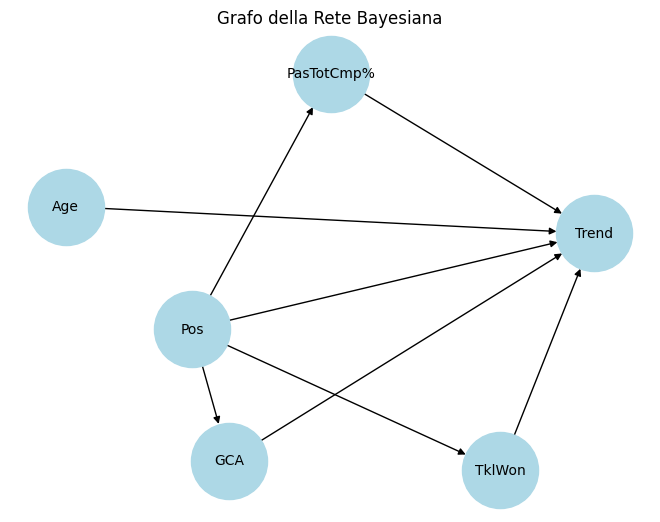

In [42]:
import networkx as nx
import matplotlib.pyplot as plt

# Crea un grafo NetworkX vuoto
G = nx.DiGraph()

# Aggiungi nodi al grafo (variabili della rete bayesiana)
variables = ['Pos', 'GCA', 'TklWon', 'Age', 'PasTotCmp%', 'Trend']
G.add_nodes_from(variables)

# Aggiungi archi al grafo in base alla struttura della rete bayesiana
edges = [('Pos', 'GCA'), ('Pos', 'PasTotCmp%'), ('Pos', 'TklWon'),
         ('Age', 'Trend'), ('GCA', 'Trend'), ('PasTotCmp%', 'Trend'), ('TklWon', 'Trend'), ('Pos', 'Trend')]
G.add_edges_from(edges)

# Disegna il grafo
pos = nx.spring_layout(G, seed=33)  # Layout per la visualizzazione
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_color='black')
plt.title("Grafo della Rete Bayesiana")
plt.show()

### Rete variata

In [43]:
from sklearn.model_selection import train_test_split
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, roc_auc_score, confusion_matrix
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import LabelBinarizer

# Carica il dataset CSV in un DataFrame
data = pd.read_csv('players_data.csv')

# Definisci le variabili della rete bayesiana
variables = ['Pos', 'GCA', 'TklWon', 'Age', 'PasTotCmp%', 'Trend']

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Discretizza le variabili
discretized_columns = ['GCA', 'TklWon', 'Age', 'PasTotCmp%']
for col in discretized_columns:
    train_data[col] = pd.cut(train_data[col], bins=5, labels=['bb', 'b', 'a', 'g', 'gg'])
    test_data[col] = pd.cut(test_data[col], bins=5, labels=['bb', 'b', 'a', 'g', 'gg'])

model = BayesianNetwork([('Pos', 'GCA'), ('Pos', 'PasTotCmp%'), ('Pos', 'TklWon'),
                         ('Age', 'Trend'), ('GCA', 'Trend'), ('PasTotCmp%', 'Trend'),
                         ('TklWon', 'Trend'), ('Pos', 'Trend')])

# Stima i parametri della rete dalle dati
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Preparazione dei dati di test
test_input = test_data[['Pos', 'GCA', 'TklWon', 'PasTotCmp%']]
y_test = test_data['Trend']

# Effettua inferenza sulle probabilità condizionali
inference = VariableElimination(model)
y_pred = []

for index, row in test_input.iterrows():
    query = inference.query(variables=['Trend'], evidence=row.to_dict())
    predicted_class = query.values.argmax()
    y_pred.append(predicted_class)

inference = VariableElimination(model)

# Calcola le metriche di valutazione
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice di Confusione:")
print(conf_matrix)

Precision: 0.30523577499550986
Recall: 0.3333333333333333
F1-score: 0.3151935776751723
Matrice di Confusione:
[[ 2  7  4  0  1]
 [10 10 21  1  1]
 [25 10 59  3  5]
 [10  3 28  0  1]
 [ 4  3  5  0  0]]


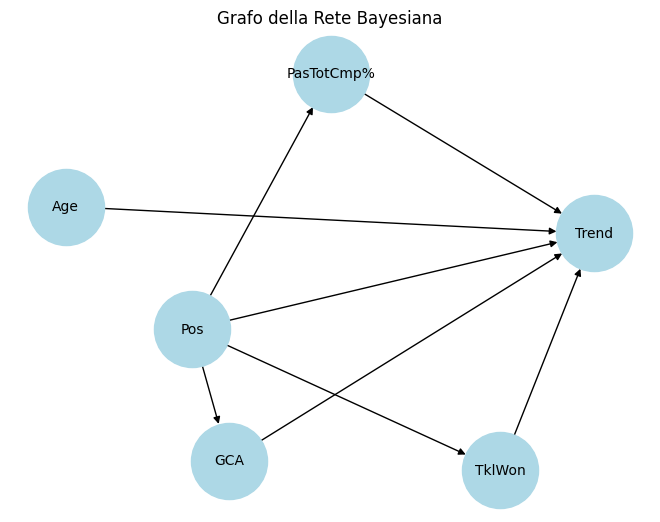

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

# Crea un grafo NetworkX vuoto
G = nx.DiGraph()

# Aggiungi nodi al grafo (variabili della rete bayesiana)
variables = ['Pos', 'GCA', 'TklWon', 'Age', 'PasTotCmp%', 'Trend']
G.add_nodes_from(variables)

# Aggiungi archi al grafo in base alla struttura della rete bayesiana
edges = [('Pos', 'GCA'), ('Pos', 'PasTotCmp%'), ('Pos', 'TklWon'),
         ('Age', 'Trend'), ('GCA', 'Trend'), ('PasTotCmp%', 'Trend'), ('TklWon', 'Trend'), ('Pos', 'Trend')]
G.add_edges_from(edges)

# Disegna il grafo
pos = nx.spring_layout(G, seed=33)  # Layout per la visualizzazione
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_color='black')
plt.title("Grafo della Rete Bayesiana")
plt.show()